In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import seaborn as sns

In [10]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
# Define the transformation
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
class DataPreparation:
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform

    def prepare_data(self,batch_size=32):
        full_dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)

        # Filter classes to ensure minimum number of samples per class
        class_counts = {class_name: 0 for class_name in full_dataset.classes}
        train_indices = []
        valid_indices = []
        test_indices = []

        for idx, (_, label) in enumerate(full_dataset.samples):
            class_counts[full_dataset.classes[label]] += 1

            if class_counts[full_dataset.classes[label]] <= 50:  # Include up to 50 samples per class in the training set
                train_indices.append(idx)
            elif 50 < class_counts[full_dataset.classes[label]] <= 60:  # For validation set
                valid_indices.append(idx)
            elif 60 < class_counts[full_dataset.classes[label]] <= 70:  # For test set
                test_indices.append(idx)

        train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
        valid_dataset = torch.utils.data.Subset(full_dataset, valid_indices)
        test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        return train_loader, valid_loader, test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# Define the model without residual connections
class Without_Residual(nn.Module):
    def __init__(self):
        super(Without_Residual, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128, 8) # Assuming 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Without_Residual().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
#Define the model with residual connections
class WithResidual(nn.Module):
    def __init__(self,dropout_rate):
        super(WithResidual, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv1_identity = nn.Conv2d(3, 32, kernel_size=1) # 1x1 conv for identity
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2_identity = nn.Conv2d(32, 64, kernel_size=1) # 1x1 conv for identity
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3_identity = nn.Conv2d(64, 128, kernel_size=1) # 1x1 conv for identity
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4_identity = nn.Conv2d(128, 256, kernel_size=1) # 1x1 conv for identity
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_identity = nn.Conv2d(256, 512, kernel_size=1) # 1x1 conv for identity
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv6_identity = nn.Conv2d(512, 1024, kernel_size=1) # 1x1 conv for identity
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128, 8)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = self.conv1_identity(x)
        out = self.pool(F.relu(self.conv1(x)))
        out += F.interpolate(identity, size=out.shape[2:])
        identity = self.conv2_identity(out)
        out = self.pool(F.relu(self.conv2(out)))
        out += F.interpolate(identity, size=out.shape[2:])
        identity = self.conv3_identity(out)
        out = self.pool(F.relu(self.conv3(out)))
        out += F.interpolate(identity, size=out.shape[2:])
        identity = self.conv4_identity(out)
        out = self.pool(F.relu(self.conv4(out)))
        out += F.interpolate(identity, size=out.shape[2:])
        identity = self.conv5_identity(out)
        out = self.pool(F.relu(self.conv5(out)))
        out += F.interpolate(identity, size=out.shape[2:])
        identity = self.conv6_identity(out)
        out = self.pool(F.relu(self.conv6(out)))
        out += F.interpolate(identity, size=out.shape[2:])
        out = out.view(out.size(0),-1)
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.fc2(out)
        return out



In [13]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch in loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy


In [14]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted== labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct_predictions / len(loader.dataset)

    return avg_loss, accuracy

In [15]:
def confusion_mat(model, loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

In [16]:
def plot_metrics(metric, learning_rate, batch_size, num_epochs, ylabel, xlabel, title):
    plt.figure(figsize=(5, 5))
    plt.plot(range(1, num_epochs + 1), metric, label=f'LR={learning_rate} BS={batch_size}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [17]:
root_dir = 'Micro_Organism'
data_prep = DataPreparation(root_dir, transform)
train_loader, valid_loader, test_loader = data_prep.prepare_data()

num_epochs = 25
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
dropout_rates = [0.2, 0.3, 0.4, 0.5]

best_accuracy = 0
best_model = None

# Training and evaluating model without residual connections
print("Training without residual connections")
# lists for model1
train_losses_model1 = []  
train_accuracies_model1 = [] 
valid_losses_model1 = [] 
valid_accuracies_model1 = [] 
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    # Training
    loss1, accuracy1 = train(model, train_loader, criterion, optimizer)
    train_losses_model1.append(loss1)
    train_accuracies_model1.append(accuracy1)
    print(f"Train Loss: {loss1:.4f}, Accuracy: {accuracy1:.4f}")

    # Validation
    val_loss1, val_accuracy1 = evaluate(model, valid_loader, criterion)
    valid_losses_model1.append(val_loss1)
    valid_accuracies_model1.append(val_accuracy1)
    print(f"Val Loss: {val_loss1:.4f}, Accuracy: {val_accuracy1:.4f}")

    if val_accuracy1 > best_accuracy:
        best_accuracy = val_accuracy1
        best_model = model

# Testing
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Training and evaluation for model with residual connections               
#lists for model2
print("Training with residual connections")  
train_losses_model2 = [] 
train_accuracies_model2 = [] 
valid_losses_model2 = []  
valid_accuracies_model2 = []  

# Residual model definition with dropout rate of 0.5 and learning rate of 0.001
model_residual = WithResidual(0.5).to(device)
optimizer_residual = optim.Adam(model_residual.parameters(), lr=0.001) 

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    print('-' * 10)

    lr = learning_rates[(epoch - 1) % len(learning_rates)]
    bs = batch_sizes[(epoch - 1) % len(batch_sizes)]
    dr = dropout_rates[(epoch - 1) % len(dropout_rates)]

    # Updating dropout and learning rate each epoch
    model_residual.dropout.p = dr
    for param_group in optimizer_residual.param_groups:
        param_group['lr'] = lr

    train_loader, valid_loader, test_loader = data_prep.prepare_data(batch_size=bs)

    train_loss, train_accuracy = train(model_residual, train_loader, criterion, optimizer_residual)
    train_losses_model2.append(train_loss)
    train_accuracies_model2.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    valid_loss, valid_accuracy = evaluate(model_residual, valid_loader, criterion)
    valid_losses_model2.append(valid_loss)
    valid_accuracies_model2.append(valid_accuracy)
    print(f"Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_accuracy:.4f}")

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model = model_residual



Training model without residual connections...
Epoch 1
Train Loss: 0.0677, Accuracy: 0.1175
Val Loss: 0.0782, Accuracy: 0.1250
Epoch 2
Train Loss: 0.0676, Accuracy: 0.1200
Val Loss: 0.0780, Accuracy: 0.1375
Epoch 3
Train Loss: 0.0674, Accuracy: 0.1775
Val Loss: 0.0772, Accuracy: 0.1125
Epoch 4
Train Loss: 0.0671, Accuracy: 0.1575
Val Loss: 0.0781, Accuracy: 0.0625
Epoch 5
Train Loss: 0.0671, Accuracy: 0.1350
Val Loss: 0.0765, Accuracy: 0.1250
Epoch 6
Train Loss: 0.0661, Accuracy: 0.1550
Val Loss: 0.0763, Accuracy: 0.2250
Epoch 7
Train Loss: 0.0664, Accuracy: 0.1725
Val Loss: 0.0762, Accuracy: 0.1250
Epoch 8
Train Loss: 0.0664, Accuracy: 0.1900
Val Loss: 0.0749, Accuracy: 0.1500
Epoch 9
Train Loss: 0.0660, Accuracy: 0.1625
Val Loss: 0.0741, Accuracy: 0.2500
Epoch 10
Train Loss: 0.0645, Accuracy: 0.2050
Val Loss: 0.0719, Accuracy: 0.2000
Epoch 11
Train Loss: 0.0643, Accuracy: 0.2100
Val Loss: 0.0717, Accuracy: 0.2250
Epoch 12
Train Loss: 0.0633, Accuracy: 0.2325
Val Loss: 0.0726, Accurac

Test Loss: 0.1827, Accuracy: 0.2250


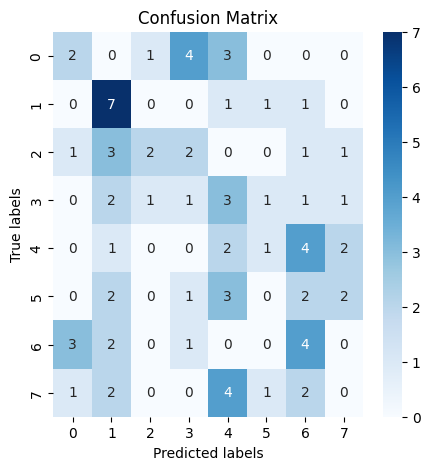

In [18]:
# Test
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
cm = confusion_mat(best_model, test_loader)
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# Define the labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

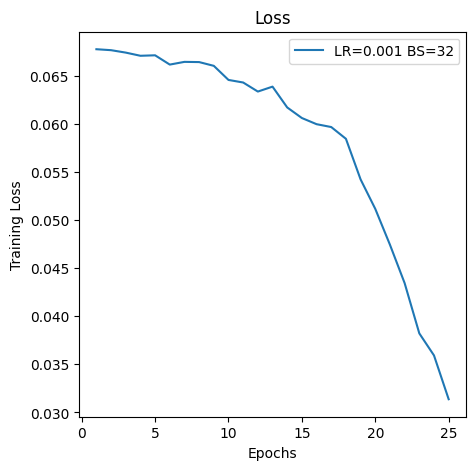

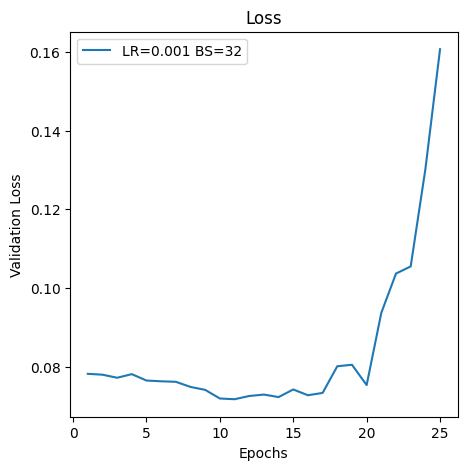

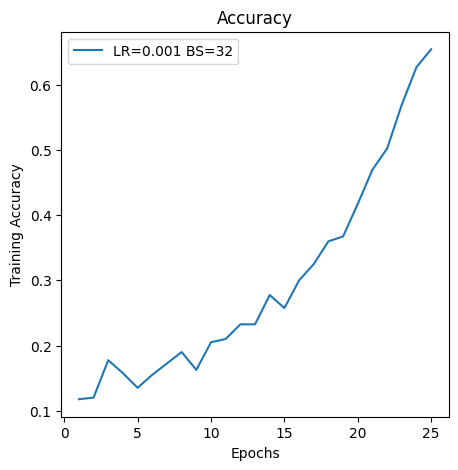

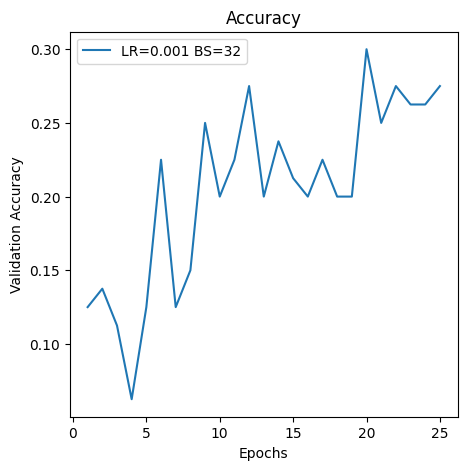

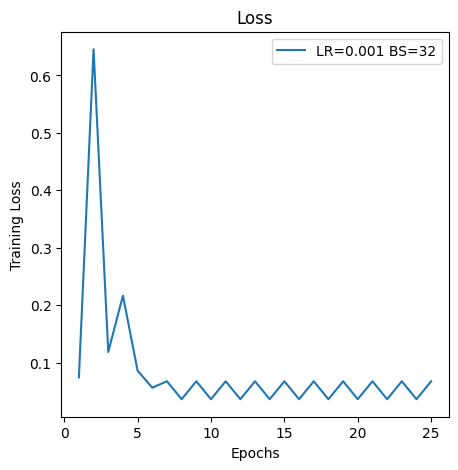

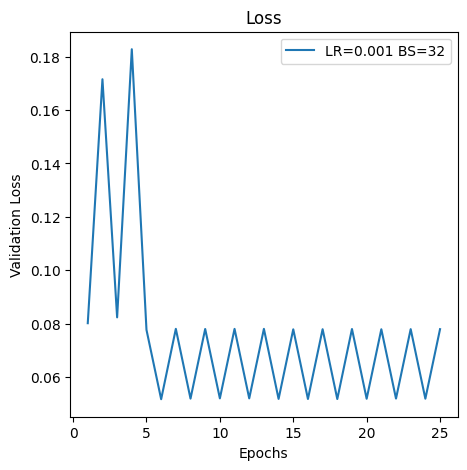

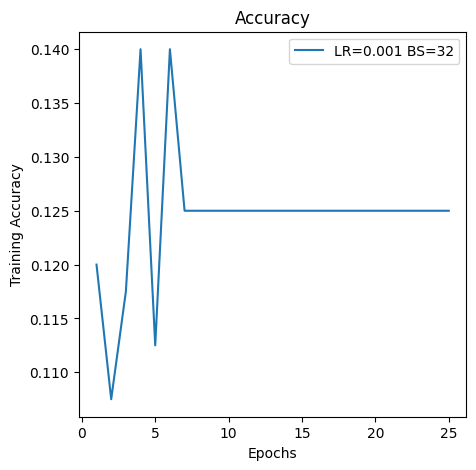

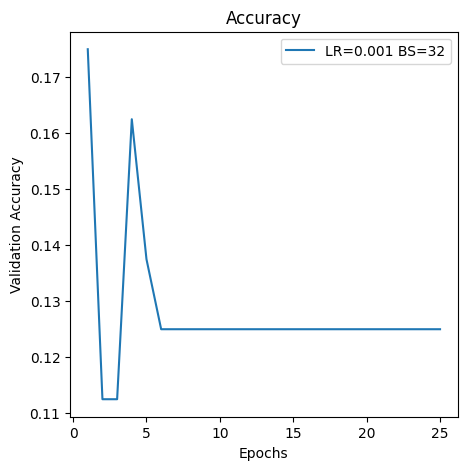

In [19]:
# Metrics for model without residual connections
plot_metrics(train_losses_model1, 0.001, 32, num_epochs, "Training Loss", "Epochs", "Loss")
plot_metrics(valid_losses_model1, 0.001, 32, num_epochs, "Validation Loss", "Epochs", "Loss")
plot_metrics(train_accuracies_model1, 0.001, 32, num_epochs, "Training Accuracy", "Epochs", "Accuracy")
plot_metrics(valid_accuracies_model1, 0.001, 32, num_epochs, "Validation Accuracy", "Epochs", "Accuracy")

# Metrics for model with residual connections
plot_metrics(train_losses_model2, 0.001, 32, num_epochs, "Training Loss", "Epochs", "Loss")
plot_metrics(valid_losses_model2, 0.001, 32, num_epochs, "Validation Loss", "Epochs", "Loss")
plot_metrics(train_accuracies_model2, 0.001, 32, num_epochs, "Training Accuracy", "Epochs", "Accuracy")
plot_metrics(valid_accuracies_model2, 0.001, 32, num_epochs, "Validation Accuracy", "Epochs", "Accuracy")


In [21]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = ImageFolder(root_dir)
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                             transforms.RandomRotation(20),
                                             transforms.Resize((220,220)),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.root_dir)

    def __getitem__(self, idx):
        img, label = self.root_dir[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [22]:
data_directory = "Micro_Organism"
# Splitting dataset
batch_size = 32
custom_dataset = CustomDataset(data_directory)
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
val_s = int(val_frac * len(custom_dataset))
train_s = int(train_frac * len(custom_dataset))
test_s = len(custom_dataset) -val_s - train_s
train_set, val_set, test_set = torch.utils.data.random_split(custom_dataset, [train_s, val_s, test_s])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

# Creating ResNet-18 model and freezing all layers except FC
resnet_model = resnet18(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(512,8)

optimizer_fn = optim.SGD(resnet_model.parameters(), lr=0.002, momentum=0.8)
criterion_fn = nn.CrossEntropyLoss()


C:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Acc: 0.211864406779661
Validation Acc: 0.3644067796610169
Validation Acc: 0.4661016949152542
Validation Acc: 0.4576271186440678
Validation Acc: 0.559322033898305
Validation Acc: 0.5423728813559322
Validation Acc: 0.5677966101694916
Validation Acc: 0.5932203389830508
Validation Acc: 0.5169491525423728
Validation Acc: 0.5847457627118644
Validation Acc: 0.6186440677966102
Validation Acc: 0.5677966101694916
Validation Acc: 0.6016949152542372
Validation Acc: 0.6186440677966102
Validation Acc: 0.6016949152542372
Validation Acc: 0.559322033898305
Validation Acc: 0.635593220338983
Validation Acc: 0.6186440677966102
Validation Acc: 0.6271186440677966
Validation Acc: 0.6016949152542372
Validation Acc: 0.6610169491525424
Validation Acc: 0.6186440677966102
Validation Acc: 0.6016949152542372
Validation Acc: 0.7033898305084746
Validation Acc: 0.6186440677966102
Test Acc: 0.6302521008403361


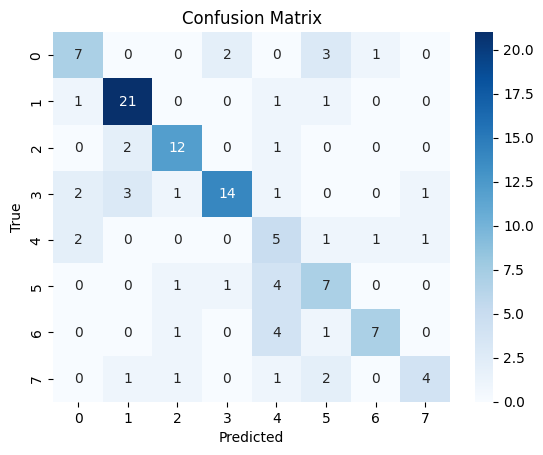

In [23]:
# Training-validating resnet model
epoch_count = 25
for epoch in range(epoch_count):
    resnet_model.train()
    for img, lbl in train_dataloader:
        optimizer_fn.zero_grad()
        out = resnet_model(img)
        loss = criterion_fn(out, lbl)
        loss.backward()
        optimizer_fn.step()

    resnet_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for img, lbl in val_dataloader:
            out = resnet_model(img)
            _, pred = torch.max(out.data, 1)
            total += lbl.size(0)
            correct += (pred == lbl).sum().item()
        accuracy = correct / total
        print(f"Validation Acc: {accuracy}")

resnet_model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for img, lbl in test_dataloader:
        out = resnet_model(img)
        _, pred = torch.max(out.data, 1)
        total += lbl.size(0)
        correct += (pred == lbl).sum().item()
    accuracy = correct / total
    print(f"Test Acc: {accuracy}")

# Confusion matrix plotting
all_preds = []
true_lbls = []
for img, lbl in test_dataloader:
    out = resnet_model(img)
    _, pred = torch.max(out.data, 1)
    all_preds.extend(pred.tolist())
    true_lbls.extend(lbl.tolist())
conf_mat = confusion_matrix(true_lbls, all_preds)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()